In [207]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [208]:
# Load the provided CSV file
file_path = r"C:\\Users\\Ericm\\PycharmProjects\\wageData\\.venv\\Scripts\\SDCountyEmployee_data_cleaned_adjusted.csv"
df = pd.read_csv(file_path, encoding='latin1')

df

,Year,EmployerName,DepartmentOrSubdivision,Position,MinPositionSalary,MaxPositionSalary,ReportedBaseWage,RegularPay,OvertimePay,LumpSumPay,OtherPay,TotalWages,DefinedBenefitPlanContribution,EmployeesRetirementCostCovered,DeferredCompensationPlan,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula
0,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,56247.0,NaN,NaN,NaN,NaN,56247.000000,NaN,2197.0,NaN,4164.000000,6361.000000,3@60
1,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,65839.0,NaN,NaN,NaN,NaN,65839.000000,NaN,2278.0,NaN,4164.000000,6442.000000,3@60
2,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,67338.0,NaN,NaN,NaN,NaN,67338.000000,NaN,4889.0,NaN,8868.000000,13757.000000,3@60
3,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,66206.0,NaN,NaN,NaN,NaN,66206.000000,NaN,4889.0,NaN,8868.000000,13757.000000,3@60
4,2009,San Diego,Air Pollution Control Dep,Asst APC Engineer,59800.000000,72675.000000,63634.0,NaN,NaN,NaN,NaN,63634.000000,NaN,2221.0,NaN,4164.000000,6385.000000,3@60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153239,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,31284.738929,13150.250241,1322.981218,3388.071112,49146.041500,4683.592901,NaN,NaN,2612.166215,7295.759115,2.7% @ 57
153240,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,23877.029832,711.128808,1750.362590,3022.649477,29361.170708,3491.572038,NaN,NaN,2168.590820,5660.162857,2.7% @ 57
153241,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,31284.738929,15075.930726,1322.981218,3388.071112,51071.721984,4683.592901,NaN,NaN,2612.166215,7295.759115,2.7% @ 57
153242,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,2693.136327,897.712109,215.450906,NaN,3806.299342,373.870690,NaN,NaN,650.577246,1024.447936,2.7% @ 57


In [209]:
# Define the keywords for positions to include and exclude
include_keywords = {}
include_keywords['Police'] = ['Police Officer', 'Police Detective', 'Police Agent', 'Police Corporal',
                    'Police Sergeant', 'Police Lieutenant', 'Police Captain', 'Police Chief', 'Chief of Police']
include_keywords['Engineer'] = ['Engineer']
include_keywords['Fire'] = ['Firefighter', 'Fire Fighter', 'Fire  Chief', 'Fire Marshal', 'Fire Division Chief', 'Fire Battalion Chief', 'Fire Battalion  Chief', 'Fire  Chief', 'Fire Bat Chief']

exclude_keywords = {}
exclude_keywords['Police'] = ['Assistant', 'Secretary', 'Assist', 'Asst', 'Trainee', 'tied', 'Reserve', 'Temp', 'Security', 'terminal', 'Terminal']
exclude_keywords['Engineer'] = ['Assistant', 'Assist', 'Asst', 'Student', 'Battalion']
exclude_keywords['Fire'] = ['Assistant', 'Assist', 'Asst', 'Volunteer', 'Student']

position = 'Fire'

# Filter for positions that contain one of the include keywords
include_filter = df['Position'].str.contains('|'.join(include_keywords[position]), case=False, na=False)

# Exclude positions containing the exclude keywords
exclude_filter = ~df['Position'].str.contains('|'.join(exclude_keywords[position]), case=False, na=False)

# Apply both filters
filtered_df = df[include_filter & exclude_filter]

#filtered_df.to_csv(f"C:/Users/Ericm\PycharmProjects\wageData\.venv\Scripts/{position}WageDataAdjusted.csv")

filtered_df

,Year,EmployerName,DepartmentOrSubdivision,Position,MinPositionSalary,MaxPositionSalary,ReportedBaseWage,RegularPay,OvertimePay,LumpSumPay,OtherPay,TotalWages,DefinedBenefitPlanContribution,EmployeesRetirementCostCovered,DeferredCompensationPlan,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula
56050,2009,Carlsbad,Fire Emergency Operations,Fire Battalion Chief,88500.000000,128300.000000,149097.0,NaN,NaN,NaN,NaN,149097.000000,NaN,10118.0,NaN,3192.000000,13310.000000,3% @ 50
56051,2009,Carlsbad,Fire Emergency Operations,Fire Battalion Chief,88500.000000,128300.000000,5030.0,NaN,NaN,NaN,NaN,5030.000000,NaN,79.0,NaN,613.000000,692.000000,3% @ 60
56052,2009,Carlsbad,Fire Emergency Operations,Fire Battalion Chief,88500.000000,128300.000000,156304.0,NaN,NaN,NaN,NaN,156304.000000,NaN,9864.0,NaN,14712.000000,24576.000000,3% @ 50
56053,2009,Carlsbad,Fire Emergency Operations,Fire Battalion Chief,88500.000000,128300.000000,152961.0,NaN,NaN,NaN,NaN,152961.000000,NaN,10118.0,NaN,11196.000000,21314.000000,3% @ 50
56054,2009,Carlsbad,Fire Emergency Operations,Fire Battalion Chief,88500.000000,128300.000000,165089.0,NaN,NaN,NaN,NaN,165089.000000,NaN,9864.0,NaN,14712.000000,24576.000000,3% @ 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153238,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,39894.326119,17169.184137,1610.953180,2088.324796,60762.788232,5696.071342,NaN,NaN,3388.071112,9084.142454,2.7% @ 57
153239,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,31284.738929,13150.250241,1322.981218,3388.071112,49146.041500,4683.592901,NaN,NaN,2612.166215,7295.759115,2.7% @ 57
153240,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,23877.029832,711.128808,1750.362590,3022.649477,29361.170708,3491.572038,NaN,NaN,2168.590820,5660.162857,2.7% @ 57
153241,2023,Vista,Fire Suppression,"Fire Fighter/Pm A,B,C",64195.920972,78060.820461,NaN,31284.738929,15075.930726,1322.981218,3388.071112,51071.721984,4683.592901,NaN,NaN,2612.166215,7295.759115,2.7% @ 57


In [210]:
filtered_df['Position'].unique()

array(['Fire Battalion  Chief', 'Fire Division Chief',
       'Paramedic Firefighter', 'Fire Marshal',
       'Fire Battalion Chief (112 Hr)', 'Fire Battalion Chief (80 Hr)',
       'Firefighter (112 Hr)', 'Firefighter (80 Hr)', 'Fire Fighter',
       'Fire Fighter - Paramedic', 'Firefighter', 'Firefighter/Paramedic',
       'Fire Battalion Chief', 'Paramedic/Firefighter',
       'Building Officer/Fire Marshall', 'Contract Deputy Fire Marshal I',
       'Deputy Fire Marshal II', 'Firefighter I',
       'Firefighter/Paramedic I', 'Firefighter/Paramedic III',
       'Probationary Firefighter/Paramedic', 'Senior Deputy Fire Marshal',
       'Dep Fire Marshall', 'Firefighter w/ PM Bonus',
       'Deputy Fire Marshal', 'Fire Battalion Chief (40 Hour)',
       'Fire Battalion Chief (56 Hour)',
       'Firefighter Paramedic (56 Hour)', 'Fire Fighter I',
       'Fire Fighter II', 'Firefighter/Paramedic (w/ FLSA)',
       'Firefighter Paramedic', 'Engineer/Firefighter',
       'Fire Fighter/Par

In [211]:
grouped_filtered_df = filtered_df.groupby(['Year', 'EmployerName']).agg(
    PositionCount=('Position', 'size'),
    MeanTotalWages=('TotalWages', 'mean')
).reset_index()

grouped_filtered_df.columns = ['Year', 'City', 'NumEmpls', 'MeanTotWage']
grouped_filtered_df

,Year,City,NumEmpls,MeanTotWage
0,2009,Carlsbad,40,100473.775000
1,2009,Chula Vista,48,95151.895833
2,2009,Coronado,16,79952.187500
3,2009,Del Mar,4,73581.750000
4,2009,El Cajon,39,89097.564103
...,...,...,...,...
264,2023,San Diego,516,80024.935140
265,2023,San Marcos,35,90121.766209
266,2023,Santee,35,80018.305603
267,2023,Solana Beach,7,93694.187658


In [212]:

grouped_filtered_df['NumEmpls%Chg'] = grouped_filtered_df.groupby(['City'])['NumEmpls'].pct_change()
grouped_filtered_df['MeanTotWage%Chg'] = grouped_filtered_df.groupby(['City'])['MeanTotWage'].pct_change()

#grouped_filtered_df.to_csv(f"C:/Users/Ericm\PycharmProjects\wageData\.venv\Scripts/{position}_RoC.csv")

grouped_filtered_df

,Year,City,NumEmpls,MeanTotWage,NumEmpls%Chg,MeanTotWage%Chg
0,2009,Carlsbad,40,100473.775000,NaN,NaN
1,2009,Chula Vista,48,95151.895833,NaN,NaN
2,2009,Coronado,16,79952.187500,NaN,NaN
3,2009,Del Mar,4,73581.750000,NaN,NaN
4,2009,El Cajon,39,89097.564103,NaN,NaN
...,...,...,...,...,...,...
264,2023,San Diego,516,80024.935140,0.011765,0.029088
265,2023,San Marcos,35,90121.766209,0.000000,-0.037241
266,2023,Santee,35,80018.305603,-0.054054,0.099156
267,2023,Solana Beach,7,93694.187658,0.400000,-0.060315


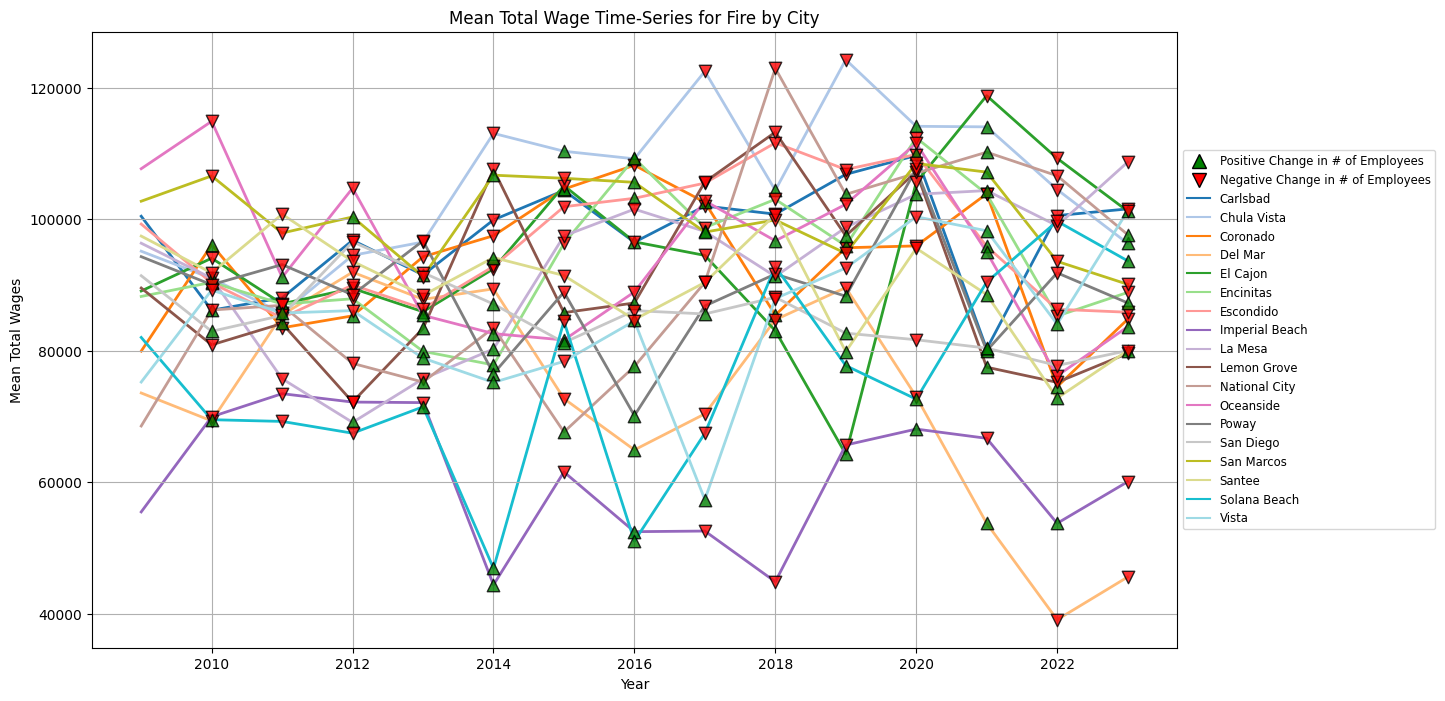

In [213]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# If position is not null, filter for that position only
def plot_wage_timeseries(df, position, filter, save_path=None):
    # Convert columns to appropriate types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['NumEmpls%Chg'] = pd.to_numeric(df['NumEmpls%Chg'], errors='coerce')
    df['MeanTotWage'] = pd.to_numeric(df['MeanTotWage'], errors='coerce')
    
    # Filter by position if provided
    if filter:
        df = df[df['Position'] == filter]
    
    # Get a list of cities in the dataset
    cities = df['City'].unique()
    
    # Use a distinct color map that can generate unique colors for each city
    num_cities = len(cities)
    cmap = plt.get_cmap('tab20', num_cities)  # 'tab20' is good for categorical data with many distinct colors
    
    # Plotting
    plt.figure(figsize=(14, 8))

    city_colors = {}

    for i, city in enumerate(cities):
        city_data = df[df['City'] == city]
        
        # Separate the data into positive and negative employee change
        positive_change = city_data[city_data['NumEmpls%Chg'] > 0]
        negative_change = city_data[city_data['NumEmpls%Chg'] <= 0]
        
        # Assign and store a unique color for each city from the colormap
        color = cmap(i)
        city_colors[city] = color
        
        # Plot time-series for the city without markers on the line
        plt.plot(city_data['Year'], city_data['MeanTotWage'], label=city, color=color, linestyle='-', linewidth=2, zorder=1)
        
        # Overlay smaller markers for positive and negative employee changes with higher zorder
        plt.scatter(positive_change['Year'], positive_change['MeanTotWage'], 
                    color='green', marker='^', s=80, edgecolor='black', alpha=0.8, zorder=2)
        plt.scatter(negative_change['Year'], negative_change['MeanTotWage'], 
                    color='red', marker='v', s=80, edgecolor='black', alpha=0.8, zorder=2)
    
    plt.title(f'Mean Total Wage Time-Series for {position} by City')
    plt.xlabel('Year')
    plt.ylabel('Mean Total Wages')
    
    # Create custom handles for the legend to only show one instance of the markers
    custom_handles = [
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Positive Change in # of Employees', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Negative Change in # of Employees', markeredgecolor='black')
    ]
    
    # Add city-specific handles with unique colors
    city_handles = [plt.Line2D([0], [0], color=city_colors[city], label=city) for city in cities]
    
    plt.legend(handles=custom_handles + city_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to avoid cutting off the legend
        
    plt.show()

# Example usage with your DataFrame
plot_wage_timeseries(grouped_filtered_df, position=position, filter = None, save_path=f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{position}WagesNumEmployeesViz.pdf")

In [214]:
import pandas as pd
import statsmodels.api as sm

# Convert 'City' to numeric codes if necessary
grouped_filtered_df['City'] = grouped_filtered_df['City'].astype('category').cat.codes
grouped_filtered_df['Year'] = pd.to_numeric(grouped_filtered_df['Year'])

# Create a lagged variable for NumEmpls%Chg by shifting it by 1 year within each city
#grouped_filtered_df['MeanTotWage%Chg_Lagged'] = grouped_filtered_df.groupby('City')['NumEmpls%Chg'].shift(1)

# Define the dependent variable
y = pd.to_numeric(grouped_filtered_df['MeanTotWage%Chg'], errors='coerce')

# Define the independent variables, including the lagged NumEmpls%Chg
X = grouped_filtered_df[['City', 'Year', 'NumEmpls%Chg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Drop missing values that resulted from the lagging operation
X = X.dropna()
y = y[X.index]

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        MeanTotWage%Chg   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     40.40
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.81e-21
Time:                        15:17:08   Log-Likelihood:                 165.62
No. Observations:                 251   AIC:                            -323.2
Df Residuals:                     247   BIC:                            -309.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2575      3.981      0.065   